# Training 4 layer CNN

## Google Drive Settings




In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/icdss')

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

## Data Preprocessing

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from reader import get_images
from keras import utils
from sklearn.model_selection import train_test_split
import itertools

Using TensorFlow backend.


In [2]:
#import dataset
(x_train, y_train_raw), (x_test, y_test_raw) = get_images() 

# Reshape data to image's dimension 28 by 28
x_train = x_train.reshape(-1,28,28)
x_test = x_test.reshape(-1,28,28)

#add another dimension to the data
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train.shape , x_test.shape

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)


C:\Users\tansi\Projects\ICDSS-FashionMNIST\reader.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x_train = df_train.drop('label', axis=1).as_matrix().astype(np.uint8)
C:\Users\tansi\Projects\ICDSS-FashionMNIST\reader.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_train = df_train['label'].as_matrix().astype(np.uint8)
C:\Users\tansi\Projects\ICDSS-FashionMNIST\reader.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x_test = df_test.drop('label', axis=1).as_matrix().astype(np.uint8)
C:\Users\tansi\Projects\ICDSS-FashionMNIST\reader.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_test = df_test['label'].as_matrix().astype(np.uint8)


In [3]:
#Change classes to a categorical type
num_classes = 10
y_train = utils.to_categorical(y_train_raw, num_classes)
y_test = utils.to_categorical(y_test_raw, num_classes)

# split original training data to 80 % training data and the other 20% for validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=13)

# Check the data size
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

## Data Augmentation

In [4]:
# Random Erasing Data Augmentation
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.1, r_1=0.1, r_2=1/0.1, v_l=0, v_h=1, pixel_level=True):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [22]:
# All images will be rescaled by 1./255. We apply data augmentation here.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   brightness_range= [0.5,1.5],
                                   horizontal_flip=True,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   preprocessing_function=get_random_eraser(v_l=0, v_h=1))

val_datagen = ImageDataGenerator(rescale=1./255)

bs = 256

# Flow training images in batches of 32 using train_datagen generator
print("Preparing generator for train dataset")
train_generator = train_datagen.flow(x_train, 
                                     y_train, 
                                     batch_size=bs)

# Flow validation images in batches of 32 using val_datagen generator
print("Preparing generator for validation dataset")
val_generator = val_datagen.flow(x_val, 
                                 y_val,
                                 batch_size=bs)

Preparing generator for train dataset
Preparing generator for validation dataset


## Building Model


In [33]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, LeakyReLU, Flatten, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

In [44]:
def make_model(learning_rate = 0.01,
               optimizer = "adam", 
               dense_layer_sizes = 512,
               activation = 'relu'):

    model = Sequential()
    model.add(Conv2D(32, (3,3), activation = activation, input_shape = (28,28,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(68, (3,3), activation = activation, input_shape = (28,28,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(128, (3,3), activation = activation, input_shape = (28,28,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(256, (3,3), activation = activation, input_shape = (28,28,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    
    model.add(Dense(512,kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    Adam = tf.keras.optimizers.Adam(lr=learning_rate)
    SGD = tf.keras.optimizers.SGD(lr=learning_rate)

    #Choose categorical_crossentropy and Adam optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer= optimizer,
                  metrics=['accuracy'])

    return model


## Training Model

In [35]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.wrappers.scikit_learn import KerasClassifier
import types


class KerasBatchClassifier(KerasClassifier):

    def fit(self, x_train, y_train, **kwargs):

        # taken from keras.wrappers.scikit_learn.KerasClassifier.fit ###################################################
        if self.build_fn is None:
            self.model = self.__call__(**self.filter_sk_params(self.__call__))
        elif not isinstance(self.build_fn, types.FunctionType) and not isinstance(self.build_fn, types.MethodType):
            self.model = self.build_fn(**self.filter_sk_params(self.build_fn.__call__))
        else:
            self.model = self.build_fn(**self.filter_sk_params(self.build_fn))

        loss_name = self.model.loss
        if hasattr(loss_name, '__name__'):
            loss_name = loss_name.__name__

        if loss_name == 'categorical_crossentropy' and len(y_train.shape) != 2:
            y_train = to_categorical(y_train)

        ################################################################################################################

        early_stopping = EarlyStopping( patience=5, verbose=5, mode="auto")
        model_checkpoint = ModelCheckpoint("train_model_{epoch:02d}_{val_accuracy:.5f}.hdf5", verbose=5, save_best_only=True, mode="auto")

        callbacks = [early_stopping]

        epochs = self.sk_params['epochs'] if 'epochs' in self.sk_params else 50

        self.__history = self.model.fit_generator(
            train_generator,  
            validation_data=val_generator, 
            epochs=epochs,
            callbacks=callbacks
        )

        return self.__history

    def score(self, X, y, **kwargs):
        kwargs = self.filter_sk_params(Sequential.evaluate, kwargs)

        loss_name = self.model.loss
        if hasattr(loss_name, '__name__'):
            loss_name = loss_name.__name__
        if loss_name == 'categorical_crossentropy' and len(y.shape) != 2:
            y = to_categorical(y)
        outputs = self.model.evaluate(X, y, **kwargs)
        if type(outputs) is not list:
            outputs = [outputs]
        for name, output in zip(self.model.metrics_names, outputs):
            if name == 'acc':
                return output
        raise Exception('The model is not configured to compute accuracy. '
                        'You should pass `metrics=["accuracy"]` to '
                        'the `model.compile()` method.')

    @property
    def history(self):
        return self.__history

In [ ]:
model = KerasBatchClassifier(build_fn=make_model) 

# Define the range
learning_rate = [0.001, 0.01]
optimizer = ["adam", "SGD"]
dropout = [0.25, 0.5] 
dense_layer_sizes = [512, 1024]

# Prepare the Grid
param_grid = dict(learning_rate = learning_rate,
                  optimizer = optimizer,
                  dropout = dropout,
                  dense_layer_sizes = dense_layer_sizes)

# GridSearch in action
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring='neg_log_loss',
                    cv =3,
                    verbose = 2)

grid_result = grid.fit(x_train, y_train, x_val = x_val, y_val = y_val)

# Show the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [41]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

bestValidationCheckpointer = ModelCheckpoint('train_model_4CNN.hdf5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


In [45]:
model = make_model(0.01,"adam")
history = model.fit_generator(train_generator, 
                              epochs=50,
                              validation_data=val_generator, 
                              callbacks=[bestValidationCheckpointer, reduce_lr],
                              verbose = 1)

Epoch 1/50
187/188 [============================>.] - ETA: 1s - loss: 3.5539 - accuracy: 0.7063
Epoch 00001: val_loss improved from inf to 2.91436, saving model to train_model_4CNN.hdf5
188/188 [==============================] - 203s 1s/step - loss: 3.5414 - accuracy: 0.7067 - val_loss: 2.9144 - val_accuracy: 0.1287
Epoch 2/50
187/188 [============================>.] - ETA: 0s - loss: 0.7791 - accuracy: 0.8298
Epoch 00002: val_loss improved from 2.91436 to 1.59086, saving model to train_model_4CNN.hdf5
188/188 [==============================] - 188s 998ms/step - loss: 0.7780 - accuracy: 0.8300 - val_loss: 1.5909 - val_accuracy: 0.6325
Epoch 3/50
187/188 [============================>.] - ETA: 1s - loss: 0.5281 - accuracy: 0.8513
Epoch 00003: val_loss improved from 1.59086 to 0.56883, saving model to train_model_4CNN.hdf5
188/188 [==============================] - 206s 1s/step - loss: 0.5284 - accuracy: 0.8513 - val_loss: 0.5688 - val_accuracy: 0.8612
Epoch 4/50
187/188 [===============

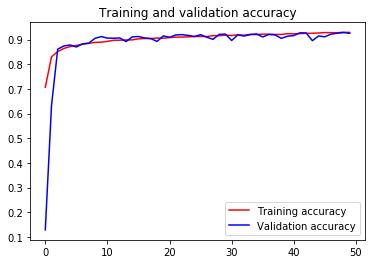

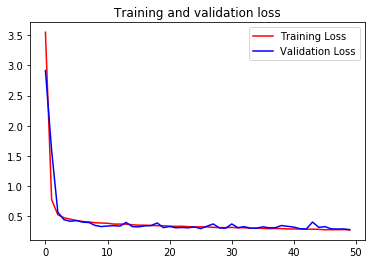

In [46]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 7.926684061869873
Test accuracy: 0.9135
